In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym
from gym_utils import AtariEnv
from gym_utils import AtariFrame

import numpy as np
import random

environment_name = "SpaceInvaders-v4"
typical_bad_game_frame_count = 1200
reward_frame_shift = -15

# environment_name = "Pong-v4"
# typical_bad_game_frame_count = 1100
# reward_frame_shift = -1

action_count = gym.make(environment_name).action_space.n

In [2]:
class AtariModel(nn.Module):

    def __init__(self, action_count, dropout=0.25):
        """
        Initialize the PyTorch AtariModel Module
        :param dropout: dropout to add in between LSTM/GRU layers
        """
        super(AtariModel, self).__init__()
        self.action_count = action_count
        
        # convolutional layer 1  (in_channels, out_channels, kernel_size, stride=1, padding=0)
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        # convolutional layer 2
        self.conv2 = nn.Conv2d(32, 128, 3, stride=1, padding=1)
        # convolutional layer 3
        self.conv3 = nn.Conv2d(128, 512, 3, stride=1, padding=1)

        # max pooling layer
        self.maxpool = nn.MaxPool2d(2, 2)
        
        #then into an RNN
        #self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.n_layers = 2
        self.hidden_dim = 512
        self.lstm = nn.LSTM(512*10*13, self.hidden_dim, self.n_layers, dropout=dropout, batch_first=True)  #10 frames???
        
        #self.fc1 = nn.Linear(8320*8, 512)  
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, action_count)
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, img_array, hidden):
        """
        Forward propagation of the neural network
        :param img_array: The input img array to the neural network
        :return
        """
        ## Define forward behavior
        #print("forward received img_array of shape: {}".format(img_array.shape))
        
        batch_size = img_array.size(0)
        sequence_length = 5 #### todo - paramertize this
        #print("batch_size: {}, sequence_length: {}".format(batch_size, sequence_length))
        
        #convolutional layers
        x = self.maxpool(F.relu(self.conv1(img_array)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))  
        
        #print("x.shape after exiting last max pool: {}".format(x.shape)) #([1, 512, 10, 13])
        
        #flatten
        x = x.view(-1, 8320*8)  
        #print("x.view shape: {}".format(x.shape))  #torch.Size([1, 8320])
        
        #out_contiguous = x.contiguous().view(-1, batch_size, 512*10*13)  #66560
        out_contiguous = x.contiguous().view(-1, sequence_length, 512*10*13)  #66560
        
        #into LTSM
        #print("out_contiguous.shape: {}, hidden[0].shape: {}".format(out_contiguous.shape, hidden[0].shape))

        r_out, hidden = self.lstm(out_contiguous, hidden) 
        
        #fc layers
        #x = self.dropout(x)
        #x = F.relu(self.fc1(x))
        r_out = self.dropout(r_out)
        r_out = F.relu(self.fc2(r_out))
        out_fc = self.fc3(r_out)
        #print("out_fc.shape: {}".format(out_fc.shape))  #out_fc.shape: torch.Size([50, 5, 6])
        #out_reshaped = out_fc.view(batch_size, -1, self.action_count)  # reshape to be batch_size first
        #out_reshaped = out_fc.view(-1, self.action_count)  # reshape to be batch_size first
        #print("out_reshaped is: {}".format(out_reshaped))
        #out = out_reshaped[:, -1] ##### get last batch of labels
        out = out_fc[:, -1, :]
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        '''
        Initialize the hidden state of an LSTM/GRU
        :param batch_size: The batch_size of the hidden state
        :return: hidden state of dims (n_layers, batch_size, hidden_dim)
        '''
        # Implement function
        
        # initialize hidden state with zero weights, and move to GPU if available
        
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
       
        return hidden


In [3]:
#play a game. feed each frame into the model and see what we get
def play_game(env_name, model, use_probability_based_action, max_frames=5000):
    model.eval()
    atari_env = AtariEnv(environment_name, reward_frame_shift)
    current_action = 0
    done = False
    frame_counter = 0
    
    hidden = model.init_hidden(1) #one batch needed for playing
    
    while not done:
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        hidden = tuple([each.data for each in hidden])
    
        atari_frame = atari_env.step(current_action)
        img_array = get_play_sequence(atari_env)
        img_tensor = torch.from_numpy(img_array).float().cuda()
        output, hidden = model(img_tensor, hidden)
        #print("output: {}".format(output))
        action_array = output.detach().cpu().numpy()[0]
        
        if use_probability_based_action:
            choices = np.arange(0,6)
            action_array_softmax = softmax(action_array)
            probability_based_action = np.random.choice(choices, p=action_array_softmax)
            #print("{} - {}".format(np.argmax(action_array), probability_based_action))

            #### use probability_based_action
            atari_frame.action_array = action_array_softmax
            current_action = probability_based_action
        else:
            atari_frame.action_array = action_array
            current_action = np.argmax(action_array)

        done = atari_frame.done_bool
        frame_counter += 1
        if frame_counter > max_frames:
            break

    atari_env.close()
    return atari_env, hidden

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def get_play_sequence(atari_env, sequence_length=5):
    frame_batch = np.zeros((sequence_length, 3, 160, 210))
    
    for ii in range(-sequence_length, 0):
        this_frame_index = len(atari_env.frame_buffer) + ii
        if this_frame_index < 0:
            this_frame_index = 0
        
        atari_frame = atari_env.frame_buffer[this_frame_index]
        
        img_array = atari_frame.img_array
        img_array = img_array.reshape((3,160,210))
        frame_batch[ii + sequence_length] = img_array
        
    return frame_batch

def get_train_batch(atari_env, batch_size, sequence_length=5):
    rand_arr = np.arange(len(atari_env.frame_buffer))
    np.random.shuffle(rand_arr)
    action_count = atari_env.env.action_space.n
    
    index_counter = 0
    batch_index_counter = 0
    frame_batch = np.zeros((batch_size*sequence_length, 3, 160, 210))
    target_batch = np.zeros(batch_size)
    reward_batch = np.zeros(batch_size)
    actions_batch = np.zeros((batch_size, action_count))
    
    for ii_batch in range(batch_size):
        batch_end_index = rand_arr[ii_batch]
        
        for ii in range(batch_end_index-sequence_length, batch_end_index):
            this_frame_index = ii
            if this_frame_index < 0:
                this_frame_index = 0

            #print("batch_end_index: {}".format(batch_end_index))
            #print("this_frame_index: {}".format(this_frame_index))
            atari_frame = atari_env.frame_buffer[this_frame_index]

            img_array = atari_frame.img_array
            img_array = img_array.reshape((3,160,210))
            frame_batch[index_counter] = img_array
      
            index_counter += 1

        reward = atari_frame.discounted_reward
        reward_batch[batch_index_counter] = reward
        
        ############# todo - update target action with the one we want based on the reward given
        
        action_array = atari_frame.action_array
        train_action = np.argmax(action_array)
        if reward < 0.25:
            train_action = np.argmin(action_array)
            #train_action = action_array.argsort()[:-1][-1] #second largest element
        target_batch[batch_index_counter] = train_action

        actions_batch[batch_index_counter] = atari_frame.action_array
        
        batch_index_counter += 1
    ############## maybe make sure we don't give too many to one action    
    
    return frame_batch, target_batch, reward_batch, actions_batch
    

def train(atari_env, model, optimizer, criterion):
    train_batch_size = 50
    model.train()
    hidden = model.init_hidden(train_batch_size)
    #print("init hidden[0] shape: {}".format(hidden[0].shape))
    action_count = atari_env.env.action_space.n
    discounted_rewards = atari_env.get_discounted_rewards()
    frame_buffer = atari_env.frame_buffer
    action_tally = np.zeros(action_count)
    train_tally = np.zeros(action_count)
    
#     reward_mean_shift = 0
#     if len(discounted_rewards) > typical_bad_game_frame_count:
#         sorted_rewards = np.sort(discounted_rewards)
#         desired_median = sorted_rewards[typical_bad_game_frame_count//2]
#         reward_mean_shift = -1.0 * desired_median
#     print("shifting rewards by: {:.3f}".format(reward_mean_shift))
    
    total_loss = 0
    epochs = 25
    #for ii, reward_ii in enumerate(discounted_rewards):
    for i in range(epochs):
    
        #print("{}: {}".format(i, reward))
        optimizer.zero_grad()
        hidden = tuple([each.data for each in hidden])
        frame_batch, target_batch, reward_batch, actions_batch = get_train_batch(atari_env, train_batch_size)
        #print("get_train_batch. frame_batch: {}, target_batch: {}, reward_batch: {}".format(frame_batch.shape, target_batch.shape, reward_batch.shape))
        
        #reward_batch = reward_batch + reward_mean_shift #shift rewards for long games
        
        #print("train frame batch shape: {}".format(frame_batch.shape))
        img_tensor = torch.from_numpy(frame_batch).float().cuda()
        output, hidden = model(img_tensor, hidden)

        target = torch.from_numpy(target_batch)
        #print("training target: {}".format(target))
        target = target.long().cuda()
        #print("output: {}, target: {}".format(output.shape, target))
        
        loss = criterion(output, target)
        #print("loss: {}".format(loss))
        total_loss += loss
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
    
    print("avg loss: {:.3f}".format(total_loss / epochs))
#    print("model action_tally: {}".format(action_tally))
#    print("train_tally:        {}".format(train_tally))


In [4]:
#new model

atari_model = AtariModel(action_count)
atari_model.cuda()

### loss function
atari_criterion = nn.CrossEntropyLoss()




In [5]:
### optimizer
atari_optimizer = optim.Adam(atari_model.parameters(), lr=0.00001)

for i in range(101):
    #play a game
    use_probability_based_action = i % 5 != 0 or i == 0
    atari_env, hidden = play_game(environment_name, atari_model, use_probability_based_action)

    #discounted_rewards = atari_env.get_discounted_rewards()
    #print()
    #print(discounted_rewards)
    print("\n{}) frames played: {}, score: {}".format(i, len(atari_env.frame_buffer), atari_env.get_total_score()))
    print("actions taken: {}".format(atari_env.get_actions_taken()))

    #train the model
    train(atari_env, atari_model, atari_optimizer, atari_criterion)



0) frames played: 552, score: 15.0
actions taken: [ 87.  71.  91. 102.  94. 107.]
avg loss: 1.681

1) frames played: 438, score: 65.0
actions taken: [ 73.  58.  52.  64. 114.  77.]
avg loss: 1.716

2) frames played: 815, score: 215.0
actions taken: [110. 104. 132. 134. 221. 114.]
avg loss: 1.729

3) frames played: 755, score: 120.0
actions taken: [126. 106. 120. 125. 183.  95.]
avg loss: 1.756

4) frames played: 919, score: 220.0
actions taken: [132. 119. 129. 136. 238. 165.]
avg loss: 1.716

5) frames played: 711, score: 270.0
actions taken: [  1.   0.   0.   0. 710.   0.]
avg loss: 1.753

6) frames played: 458, score: 80.0
actions taken: [ 90.  65.  49.  56. 126.  72.]
avg loss: 1.735

7) frames played: 766, score: 150.0
actions taken: [108. 107. 141.  89. 235.  86.]
avg loss: 1.780

8) frames played: 676, score: 125.0
actions taken: [101.  94. 105.  99. 185.  92.]
avg loss: 1.712

9) frames played: 631, score: 65.0
actions taken: [ 86.  65.  88. 108. 182. 102.]
avg loss: 1.822

10)

avg loss: 1.762

82) frames played: 691, score: 295.0
actions taken: [100.  80.  96.  92. 234.  89.]
avg loss: 1.654

83) frames played: 920, score: 295.0
actions taken: [104. 108. 111. 104. 348. 145.]
avg loss: 1.729

84) frames played: 535, score: 130.0
actions taken: [ 70.  72.  71.  72. 180.  70.]
avg loss: 1.759

85) frames played: 721, score: 270.0
actions taken: [  1.   0.   0.   0. 720.   0.]
avg loss: 1.705

86) frames played: 631, score: 110.0
actions taken: [ 71.  91.  91.  88. 215.  75.]
avg loss: 1.720

87) frames played: 670, score: 155.0
actions taken: [ 98.  95.  82.  89. 234.  72.]
avg loss: 1.762

88) frames played: 355, score: 30.0
actions taken: [ 53.  44.  47.  45. 123.  43.]
avg loss: 1.743

89) frames played: 1423, score: 440.0
actions taken: [194. 213. 214. 186. 403. 213.]
avg loss: 1.735

90) frames played: 725, score: 270.0
actions taken: [  1.   0.   0.   0. 724.   0.]
avg loss: 1.736

91) frames played: 1089, score: 325.0
actions taken: [154. 146. 163. 145. 

In [6]:
#display frame
frame_num=300
discounted_rewards = atari_env.get_discounted_rewards()

print("discounted_rewards mean: {}".format(np.mean(discounted_rewards)))


discounted_rewards mean: 1.9682624259282554e-17


frame: 304, original reward: 0.259
actions out: [-0.13122709 -0.13930713 -0.15244992 -0.19077629  0.7402337  -0.16593331]


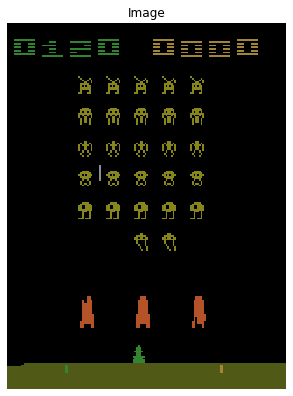

In [7]:
frame_num += 4
atari_frame = atari_env.frame_buffer[frame_num]

print("frame: {}, original reward: {:.3f}".format(frame_num, discounted_rewards[frame_num]))
print("actions out: {}".format(atari_env.frame_buffer[frame_num].action_array))

atari_frame.show_frame()

In [8]:
for i  in range(len(atari_env.frame_buffer)):
    print("actions out: {}".format(atari_env.frame_buffer[i].action_array))
    

actions out: [-0.10772737 -0.11491622 -0.13322502 -0.16233112  0.6505028  -0.14070976]
actions out: [-0.12761424 -0.13548182 -0.14949158 -0.18659449  0.7270425  -0.16233411]
actions out: [-0.13061234 -0.13865618 -0.15192127 -0.19006531  0.73801756 -0.16537887]
actions out: [-0.13111086 -0.13918598 -0.15234472 -0.19063751  0.7398198  -0.16583815]
actions out: [-0.13120182 -0.13928115 -0.15242642 -0.19074547  0.74014485 -0.16591382]
actions out: [-0.13121992 -0.1392994  -0.15244344 -0.19076796  0.7402085  -0.16592756]
actions out: [-0.13122378 -0.13930315 -0.15244722 -0.190773    0.7402219  -0.1659303 ]
actions out: [-0.13122456 -0.13930401 -0.15244806 -0.19077419  0.7402247  -0.16593093]
actions out: [-0.13122474 -0.13930418 -0.15244824 -0.19077444  0.7402253  -0.16593108]
actions out: [-0.13122477 -0.1393042  -0.15244827 -0.19077452  0.74022543 -0.16593108]
actions out: [-0.13122487 -0.13930416 -0.15244834 -0.19077456  0.7402256  -0.16593108]
actions out: [-0.13122492 -0.13930419 -0.15

In [9]:
frame_batch, target_batch, reward_batch, actions_batch = get_train_batch(atari_env, 50)

target_tally = np.zeros(6)

for i  in range(len(reward_batch)):
    print("reward: {:.4f}, target: {}".format(reward_batch[i], target_batch[i]))
    target_tally[int(target_batch[i])] += 1
    
print(target_tally)

reward: -0.8604, target: 3.0
reward: 1.3911, target: 4.0
reward: -1.1576, target: 3.0
reward: -0.0128, target: 3.0
reward: -0.4280, target: 3.0
reward: -0.4917, target: 3.0
reward: -0.8007, target: 3.0
reward: -1.0440, target: 3.0
reward: -0.7486, target: 3.0
reward: 0.5455, target: 4.0
reward: -0.7897, target: 3.0
reward: 0.6045, target: 4.0
reward: -0.6514, target: 3.0
reward: -1.1364, target: 3.0
reward: 0.8160, target: 4.0
reward: 0.3267, target: 4.0
reward: 0.5948, target: 4.0
reward: -1.1296, target: 3.0
reward: 1.0987, target: 4.0
reward: -0.2401, target: 3.0
reward: -0.1402, target: 3.0
reward: -0.9419, target: 3.0
reward: -0.3903, target: 3.0
reward: -1.0405, target: 3.0
reward: -1.1576, target: 3.0
reward: -0.9636, target: 3.0
reward: 1.4699, target: 4.0
reward: -0.2732, target: 3.0
reward: 2.4107, target: 4.0
reward: 0.1405, target: 3.0
reward: -0.1791, target: 3.0
reward: 0.3095, target: 4.0
reward: -0.3093, target: 3.0
reward: 0.2978, target: 4.0
reward: 0.9062, target: 4.